In [38]:
import matplotlib.pyplot as plt
import mdtraj as md
import numpy as np
import seaborn as sns
import torch
from loguru import logger
from omegaconf import OmegaConf
from tqdm import tqdm

from rocketshp import config
from rocketshp.data.mdcath import MDCathDataModule
from rocketshp.modeling.architectures import (
    DynCorrModelWithTemperature,
)
from rocketshp.plot import display_trajectory

In [2]:
config_file = "../configs/default_config.yml"
# checkpoint_file = fmnew = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split/model-epoch=14-train_loss=0.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=02-train_loss=2.68.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/revert_loss/model-epoch=17-train_loss=0.29.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/temperature_atlas/model-epoch=10-train_loss=0.36.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/mdcath_temp/model-epoch=00-train_loss=0.56.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/mdcath_temp_2/model-epoch=16-train_loss=0.30.pt.ckpt"

checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/mdcath_fs_shp/model-epoch=02-val_loss=1.86.pt.ckpt"

PARAMS = config.DEFAULT_PARAMETERS
PARAMS.update(OmegaConf.load(config_file))


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
logger.info(f"Device: {device}")

2025-02-15 22:39:07.911 | INFO     | __main__:<module>:16 - Device: cuda:0


In [3]:
adl = MDCathDataModule(
    config.PROCESSED_DATA_DIR / "mdcath/mdcath_processed.h5",
    seq_features=True,
    struct_features=True,
    batch_size=8,
    num_workers=PARAMS.num_data_workers,
    train_pct=PARAMS.train_pct,
    val_pct=PARAMS.val_pct,
    random_seed=PARAMS.random_seed,
    struct_stage=PARAMS.struct_stage,
    shuffle=PARAMS.shuffle,
)
adl.setup("train")
ads = adl.dataset
logger.info(
    f"{len(adl.dataset)}, {len(adl.train_data)}, {len(adl.val_data)}, {len(adl.test_data)}"
)

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/rocketshp/lib/python3.11/site-packages/esm/pretrained.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/s

2025-02-15 22:39:13.465 | INFO     | __main__:<module>:10 - 129600, 101325, 12725, 15550


In [4]:
tdl = adl.train_dataloader()
for batch in tdl:
    break

for k, v in batch[0].items():
    print(k, v.shape)

for k, v in batch[1].items():
    print(k, v.shape)

seq_feats torch.Size([8, 144, 1536])
temp torch.Size([8, 144])
struct_feats torch.Size([8, 144, 1024])
rmsf torch.Size([8, 144])
ca_dist torch.Size([8, 144, 144])
autocorr torch.Size([8, 144, 144])
shp torch.Size([8, 144, 20])


In [5]:
# model = FlexibilityModel.load_from_checkpoint(checkpoint_file, strict=False)
# model = FlexibilityModelWithTemperature.load_from_checkpoint(checkpoint_file, strict=False)
model = DynCorrModelWithTemperature.load_from_checkpoint(checkpoint_file, strict=False)
model = model.to(device)
model.eval()

/mnt/home/ssledzieski/Projects/rocketshp/rocketshp/modeling/architectures.py:493: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(checkpoint_path)


DynCorrModelWithTemperature(
  (encoder): JointStructAndSequenceEncoder(
    (seq_emb): SeqEncoder(
      (linear): Sequential(
        (0): Linear(in_features=1536, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
    (struct_emb): SeqEncoder(
      (linear): Sequential(
        (0): Linear(in_features=1024, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (transformer): TransformerStack(
    (blocks): ModuleList(
      (0-3): 4 x UnifiedTransformerBlock(
        (attn): MultiHeadAttention(
          (layernorm_qkv): Sequential(
            (0): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
            (1): Linear(in_features=256, out_features=768, bias=False)
          )
          (out_proj): Linear(in_features=256, out_features=256, bias=False)
          (q_ln): LayerNorm((2

15000

2025-02-15 23:31:00.188 | INFO     | __main__:<module>:26 - Key: 1a87A02/T320/R0
2025-02-15 23:31:00.218 | INFO     | __main__:<module>:42 - Temperature: T320
2025-02-15 23:31:00.240 | INFO     | __main__:<module>:42 - Temperature: T348
2025-02-15 23:31:00.248 | INFO     | __main__:<module>:42 - Temperature: T379
2025-02-15 23:31:00.255 | INFO     | __main__:<module>:42 - Temperature: T413
2025-02-15 23:31:00.263 | INFO     | __main__:<module>:42 - Temperature: T450


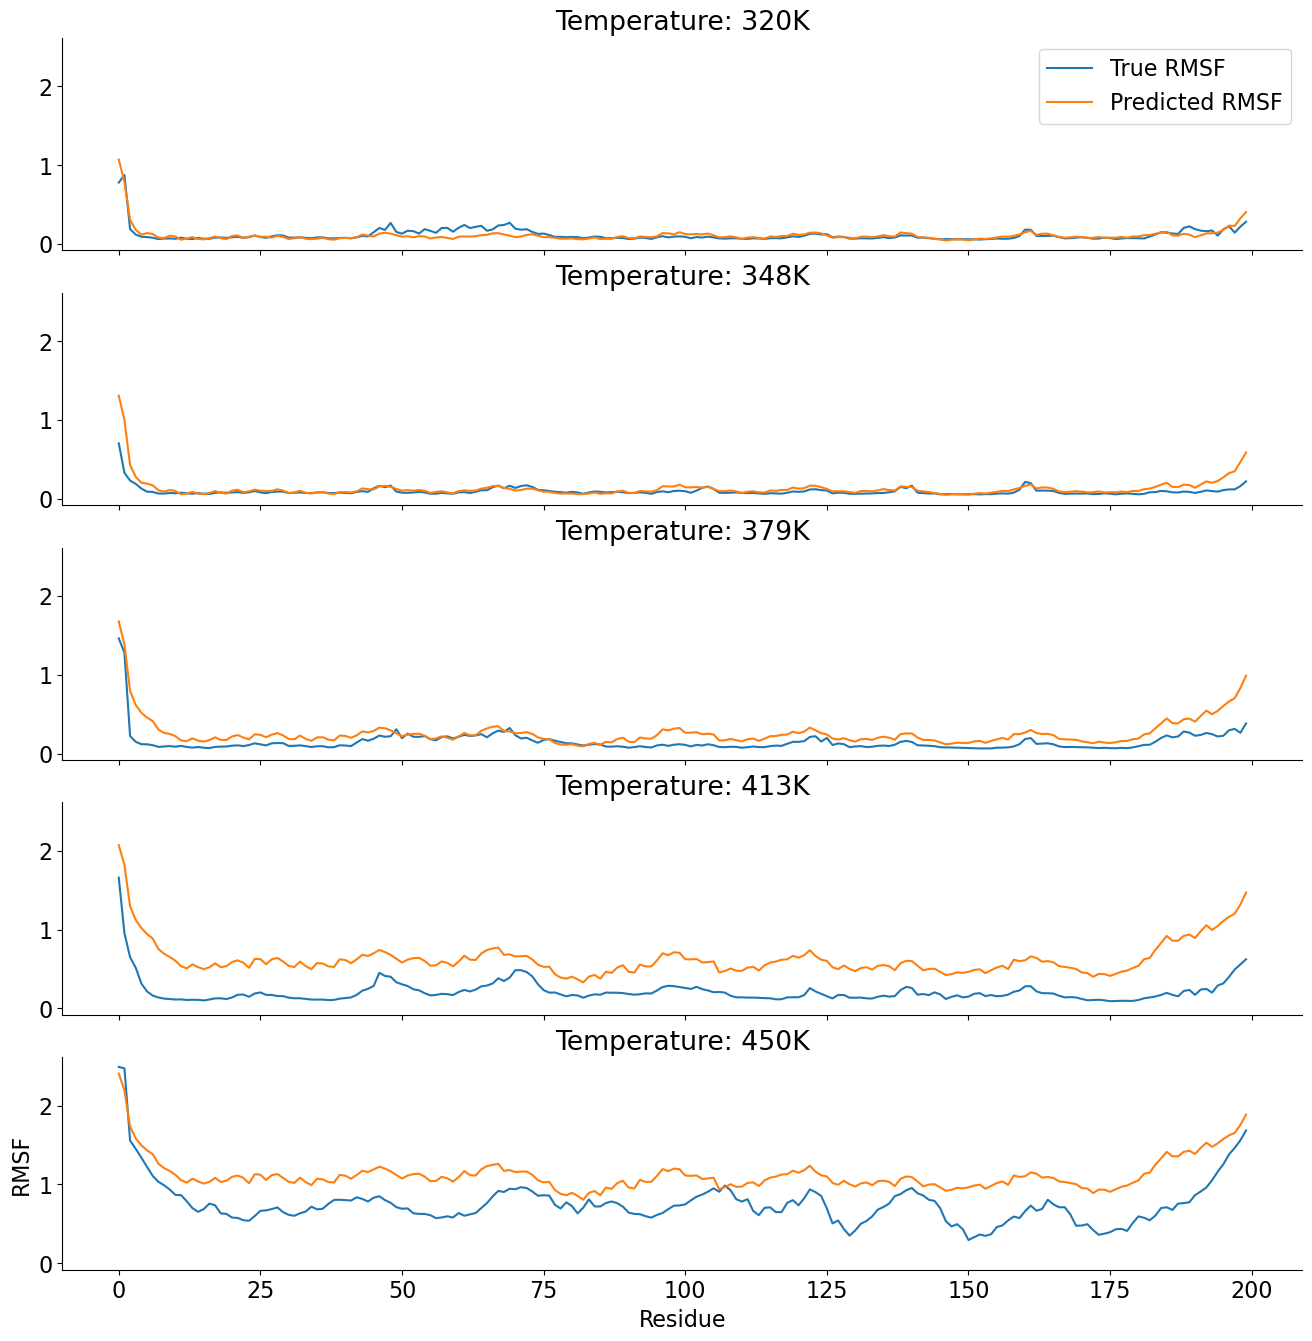

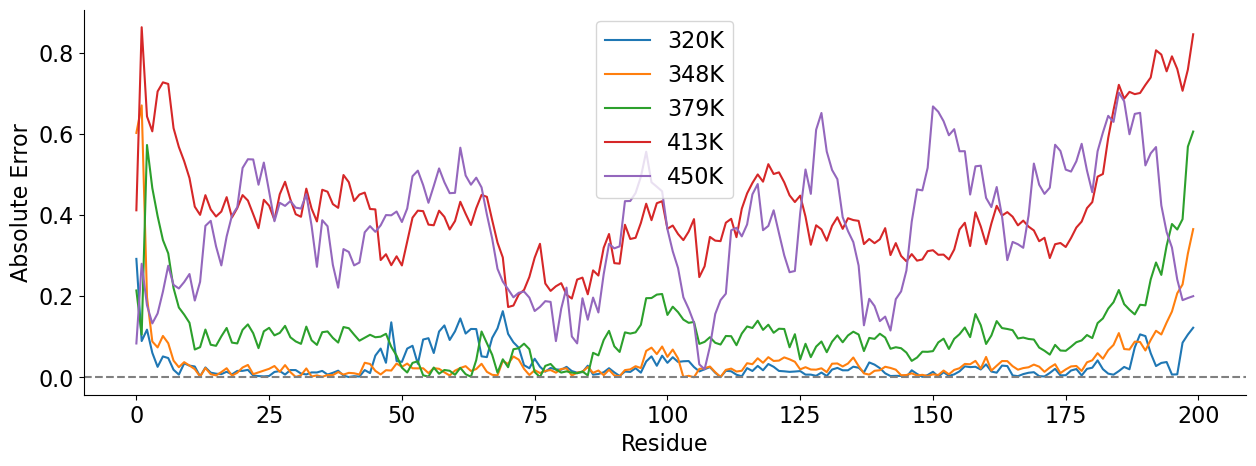

In [117]:
TEMPS = [320, 348, 379, 413, 450]

### by key ###
# DATA_SUBSET = adl.test_data
DATA_SUBSET = adl.val_data
# DATA_SUBSET = adl.train_data


def get_idx_name(name):
    return adl.dataset.samples.index(name)


# key = "4yl4A00/T320/R0"
# SAMPLE_I = DATA_SUBSET.indices.index(get_idx_name(key))

### by index ###

SAMPLE_I = 100  # **

# SAMPLE_I = 300
# SAMPLE_I = 400
# SAMPLE_I = 1200
# SAMPLE_I = 1300
# SAMPLE_I = SAMPLE_I * 5

key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
logger.info(f"Key: {key}")
####################

plt.rcParams.update({"font.size": 16})
fig, ax = plt.subplots(len(TEMPS), 1, figsize=(16, 16), sharex=True, sharey=True)

temp_error = {}
shp_results = {}
for i, t in enumerate(TEMPS):
    sample_temp = SAMPLE_I + i

    feats, labels = DATA_SUBSET[sample_temp]
    key = adl.dataset.samples[DATA_SUBSET.indices[sample_temp]]

    pdb_code, temp_str, rep_str = key.split("/")
    logger.info(f"Temperature: {temp_str}")
    pdb_code_save = pdb_code
    # pdb_code_save = pdb_code + "_seqOnly"
    ##############

    with torch.no_grad():
        both_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})
        true = labels["rmsf"]
        pred = both_result["rmsf"].detach().cpu().numpy().squeeze()
        temp_error[t] = true - pred
        shp_results[t] = (
            labels["shp"],
            both_result["shp"].detach().cpu().numpy().squeeze(),
        )

    ax[i].plot(true, label="True RMSF")
    ax[i].plot(pred, label="Predicted RMSF")
    ax[i].set_title(f"Temperature: {t}K")
    if i == 0:
        ax[i].legend(loc="upper right")

plt.ylabel("RMSF")
plt.xlabel("Residue")
# plt.title(f"Protein: {key}")
sns.despine()
plt.savefig(
    config.PROJ_ROOT / "img" / f"{pdb_code_save}_rmsf_comparison.svg",
    bbox_inches="tight",
)
plt.show()
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for t, r in temp_error.items():
    plt.plot(np.abs(r), label=f"{t}K")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Residue")
plt.ylabel("Absolute Error")
plt.legend()
sns.despine()
plt.savefig(
    config.PROJ_ROOT / "img" / f"{pdb_code_save}_rmsf_error.svg", bbox_inches="tight"
)
plt.show()
plt.close()

In [118]:
pdb_code, temp, rep = key.split("/")
temp = temp.lstrip("T")
rep = rep.lstrip("R")
traj = md.load_xtc(
    config.PROCESSED_DATA_DIR / f"mdcath/{pdb_code}/{pdb_code}_{temp}_{rep}.xtc",
    top=config.PROCESSED_DATA_DIR / f"mdcath/{pdb_code}/{pdb_code}.pdb",
)
traj.superpose(traj, 0)
traj.center_coordinates()
# view = display_trajectory(traj, bfactor=bf_both, coloring="bfactor", normalize=True, RMAX=2)
view = display_trajectory(traj)
view

NGLWidget(max_frame=439)

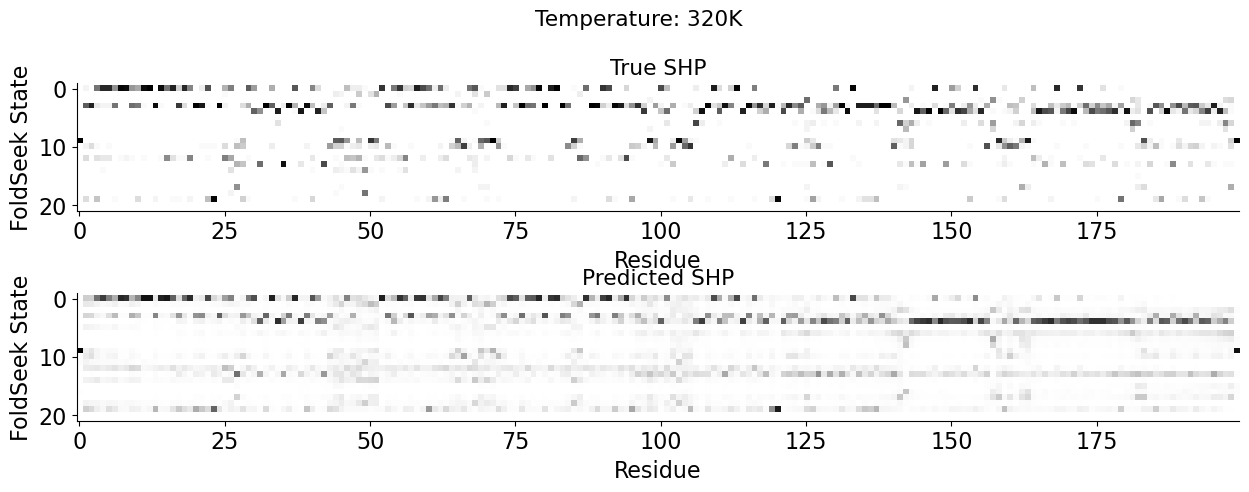

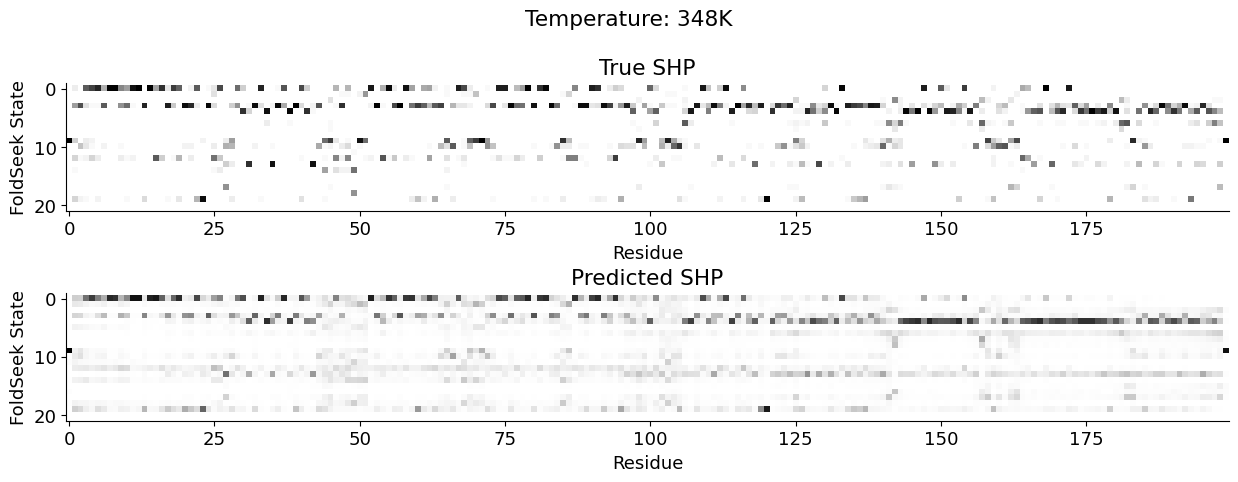

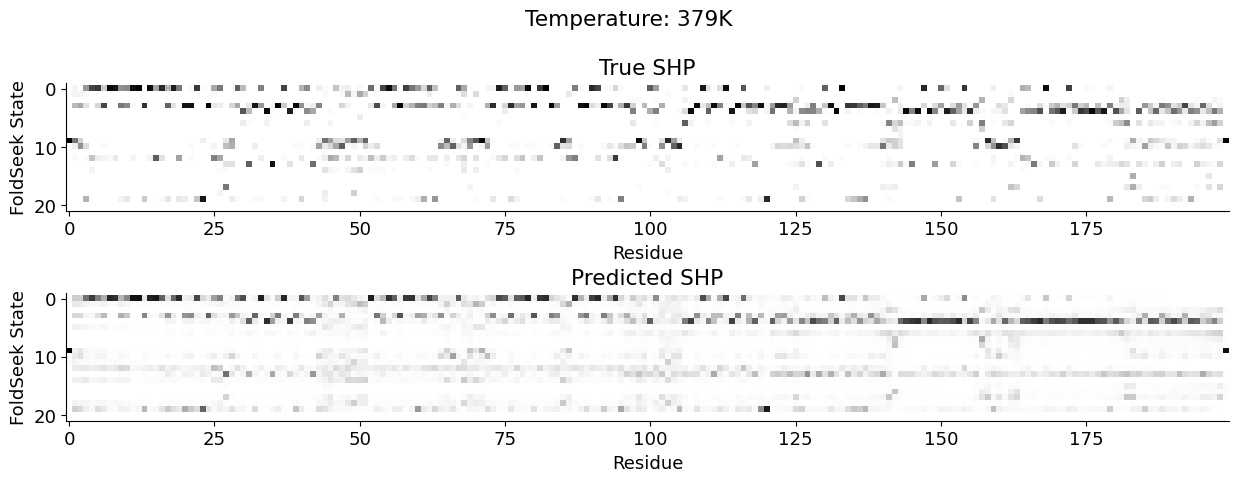

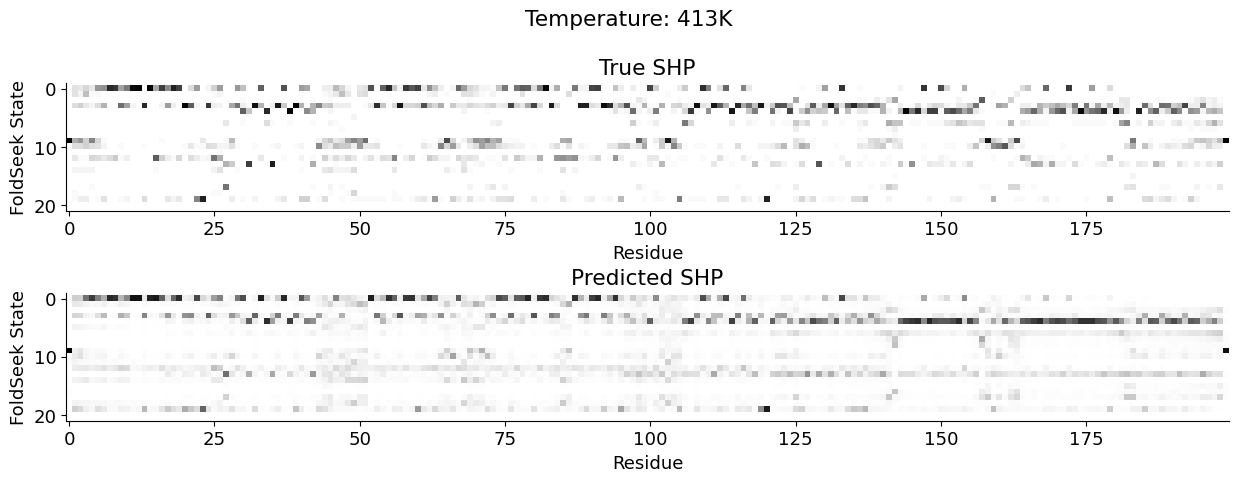

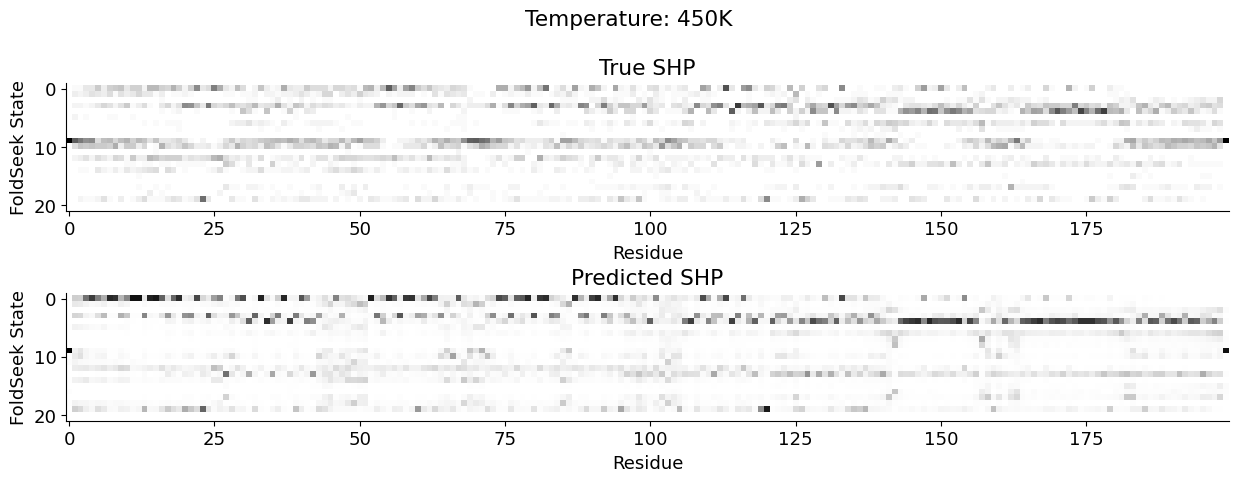

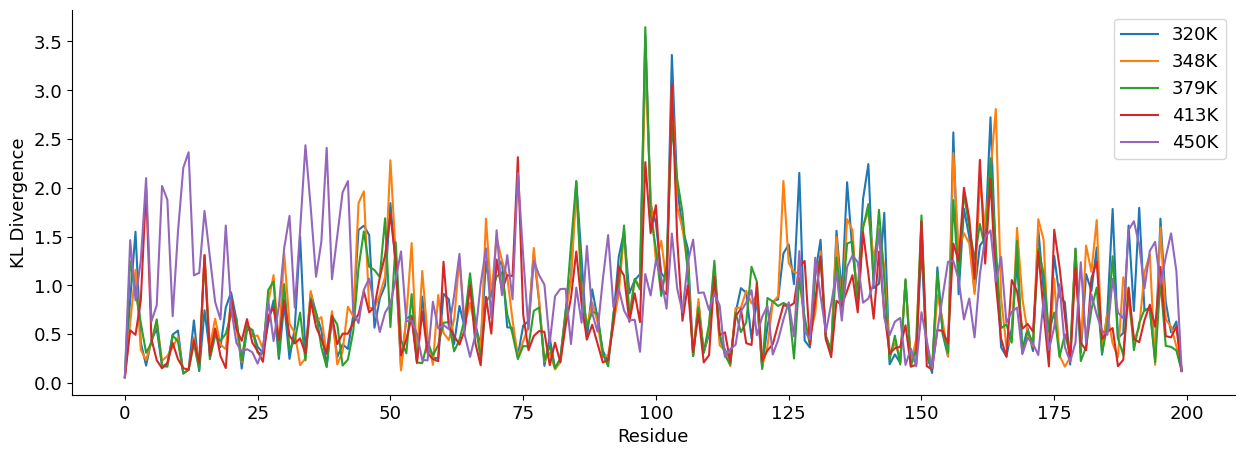

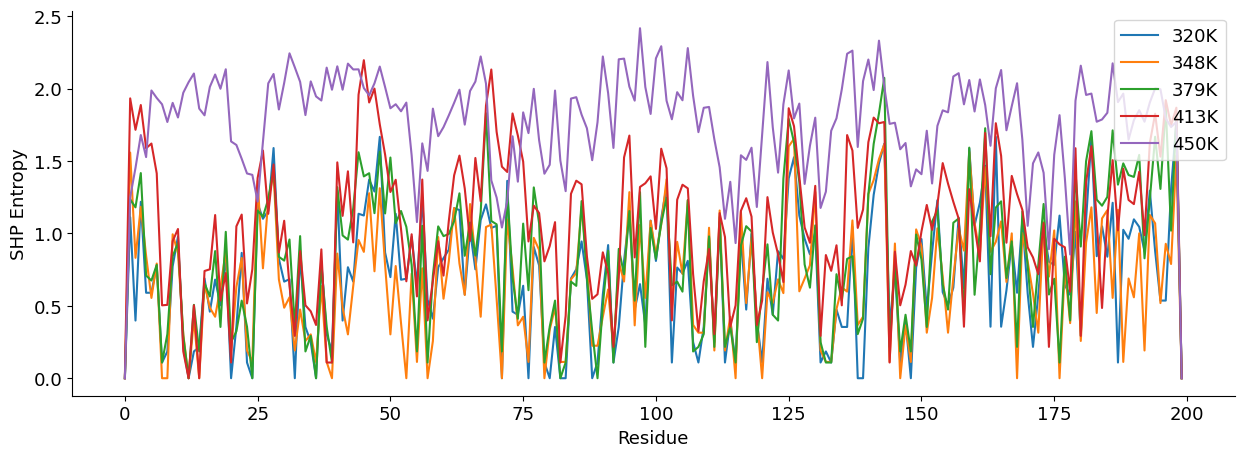

2025-02-15 23:31:32.068 | INFO     | __main__:<module>:64 - Temperature: 320K, Entropy: 0.7081497311592102
2025-02-15 23:31:32.068 | INFO     | __main__:<module>:64 - Temperature: 348K, Entropy: 0.6709896922111511
2025-02-15 23:31:32.069 | INFO     | __main__:<module>:64 - Temperature: 379K, Entropy: 0.8326585292816162
2025-02-15 23:31:32.069 | INFO     | __main__:<module>:64 - Temperature: 413K, Entropy: 1.0662524700164795
2025-02-15 23:31:32.070 | INFO     | __main__:<module>:64 - Temperature: 450K, Entropy: 1.7748826742172241


In [119]:
# Foldseek Structure Heterogeneity Profile
from scipy.stats import entropy
from torch.nn.functional import kl_div, log_softmax, softmax

shp_errors = {}
pred_entropy = {}
true_entropy = {}
for i, t in enumerate(TEMPS):
    fig, ax = plt.subplots(2, 1, figsize=(15, 5))

    true_shp = shp_results[t][0].cpu().squeeze().T
    predicted_shp = torch.from_numpy(shp_results[t][1]).squeeze().T

    # compute kl divergence
    shp_errors[t] = kl_div(
        log_softmax(predicted_shp, dim=0), true_shp, log_target=False, reduction="none"
    )
    pred_entropy[t] = entropy(softmax(predicted_shp, dim=0), axis=0)
    true_entropy[t] = entropy(true_shp, axis=0)

    plt.rcParams.update({"font.size": 13})
    ax[0].imshow(true_shp, cmap="binary")
    ax[0].set_xlabel("True")
    ax[0].set_ylim(21, -1)
    ax[0].set_title("True SHP")
    ax[0].set_xlabel("Residue")
    ax[0].set_ylabel("FoldSeek State")

    ax[1].imshow(softmax(predicted_shp, dim=0), cmap="binary")
    # ax[1].imshow(predicted_shp, cmap="binary")
    ax[1].set_title("Predicted SHP")
    ax[1].set_ylabel("FoldSeek State")
    ax[1].set_xlabel("Residue")
    ax[1].set_ylim(21, -1)
    plt.suptitle(f"Temperature: {t}K")
    sns.despine()

    plt.savefig(
        config.PROJ_ROOT / "img" / f"{pdb_code_save}_shp_temp{t}_comparison.svg",
        bbox_inches="tight",
    )
    plt.show()
    plt.close()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for t, r in shp_errors.items():
    plt.plot(r.sum(dim=0), label=f"{t}K")
plt.xlabel("Residue")
plt.ylabel("KL Divergence")
plt.legend()
sns.despine()
plt.savefig(
    config.PROJ_ROOT / "img" / f"{pdb_code_save}_shp_kl_divergence.svg",
    bbox_inches="tight",
)
plt.show()
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(15, 5))
for t, r in true_entropy.items():
    plt.plot(r, label=f"{t}K")
plt.xlabel("Residue")
plt.ylabel("SHP Entropy")
plt.legend(loc="upper right")
sns.despine()
plt.savefig(
    config.PROJ_ROOT / "img" / f"{pdb_code_save}_shp_true_entropy.svg",
    bbox_inches="tight",
)
plt.show()
plt.close()

for t in TEMPS:
    logger.info(f"Temperature: {t}K, Entropy: {true_entropy[t].mean()}")

---
## Variance of RMSF within different subsets of a trajectory

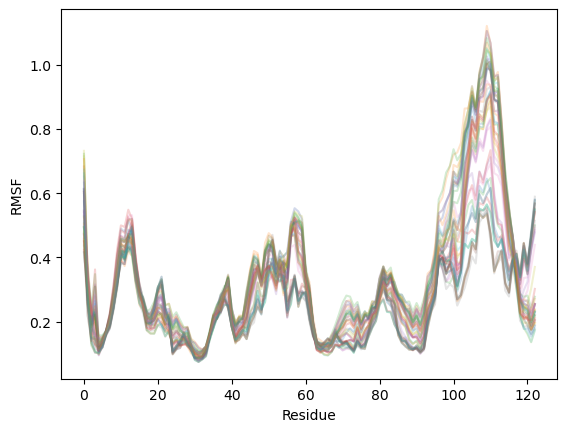

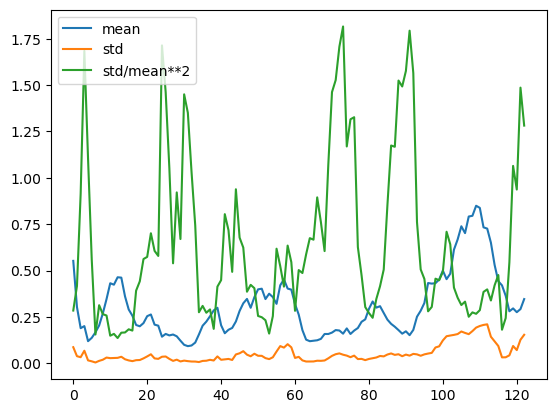

In [7]:
import numpy as np

subsample_rmsf = []
for _ in range(50):
    start = np.random.randint(0, traj.n_frames // 2)
    stride = 5
    t_sub = traj[start : start + traj.n_frames // 2 : stride]
    sample = md.rmsf(t_sub, t_sub, 0, atom_indices=traj.top.select("name CA"))
    subsample_rmsf.append(sample)

subsample_rmsf = np.stack(subsample_rmsf)
import matplotlib.pyplot as plt

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.T, alpha=0.2)
plt.xlabel("Residue")
plt.ylabel("RMSF")
plt.show()

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.mean(axis=0), label="mean")
plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.std(axis=0), label="std")
plt.plot(
    np.arange(subsample_rmsf.shape[1]),
    subsample_rmsf.std(axis=0) / subsample_rmsf.mean(axis=0) ** 2,
    label="std/mean**2",
)

plt.legend()
plt.show()

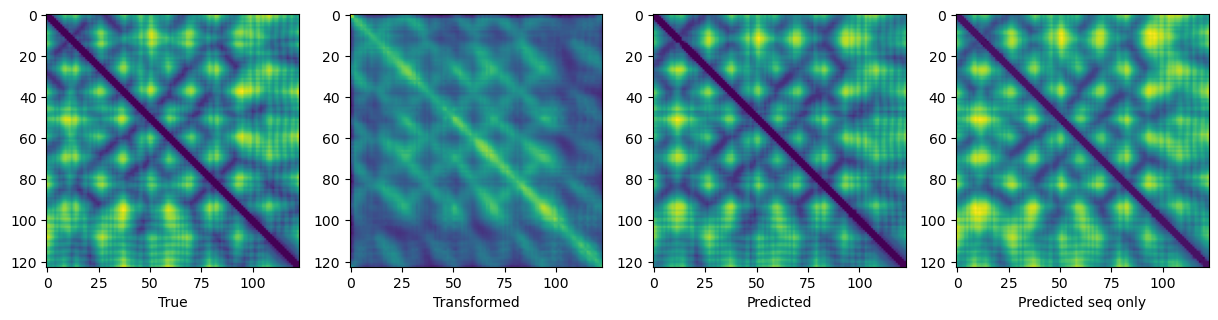

In [11]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))

true_sqform = md.geometry.squareform(
    *md.compute_contacts(traj[0], scheme="ca", ignore_nonprotein=True)
)
transform_sqform = (
    model._cross_transform({k: v.unsqueeze(0) for k, v in feats.items()})
    .squeeze()
    .detach()
    .cpu()
    .numpy()
)


ax[0].imshow(true_sqform.squeeze())
ax[0].set_xlabel("True")
ax[1].imshow(transform_sqform)
ax[1].set_xlabel("Transformed")
ax[2].imshow(sqfm_both.squeeze())
ax[2].set_xlabel("Predicted")
ax[3].imshow(sqfm_seqonly.squeeze())
ax[3].set_xlabel("Predicted seq only")
plt.show()

---

### Compare across  temperatures

In [17]:
import numpy as np

DATA_SUBSET = adl.test_data
BASE_SAMPLE_I = 15005
# BASE_SAMPLE_I = 15010
# BASE_SAMPLE_I = 0

all_results = []
residuals = []
for rep in [0, 1, 2, 3, 4]:
    SAMPLE_I = BASE_SAMPLE_I + rep

    feats, labels = DATA_SUBSET[SAMPLE_I]
    key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
    logger.info(key)
    temp = int(key.split("/")[1].lstrip("T"))

    with torch.no_grad():
        both_result = model({k: v.unsqueeze(0) for k, v in feats.items()})
        yhat_both = both_result["rmsf"]
        bf_both = yhat_both.detach().cpu().numpy().squeeze()
        all_results.append((yhat_both, bf_both))
        residuals.append(np.abs(labels["rmsf"] - bf_both))

2025-01-16 13:33:21.356 | INFO     | __main__:<module>:14 - 4yl4A00/T320/R1
2025-01-16 13:33:21.374 | INFO     | __main__:<module>:14 - 4yl4A00/T348/R1
2025-01-16 13:33:21.390 | INFO     | __main__:<module>:14 - 4yl4A00/T379/R1
2025-01-16 13:33:21.407 | INFO     | __main__:<module>:14 - 4yl4A00/T413/R1
2025-01-16 13:33:21.423 | INFO     | __main__:<module>:14 - 4yl4A00/T450/R1


In [18]:
pdb_code, temp, rep = key.split("/")
temp = temp.lstrip("T")
rep = rep.lstrip("R")
traj = md.load_xtc(
    config.PROCESSED_DATA_DIR / f"mdcath/{pdb_code}/{pdb_code}_{temp}_{rep}.xtc",
    top=config.PROCESSED_DATA_DIR / f"mdcath/{pdb_code}/{pdb_code}.pdb",
)
traj.superpose(traj, 0)
traj.center_coordinates()
view = display_trajectory(
    traj, bfactor=bf_both, coloring="bfactor", normalize=True, RMAX=2
)
view

NGLWidget(max_frame=129)

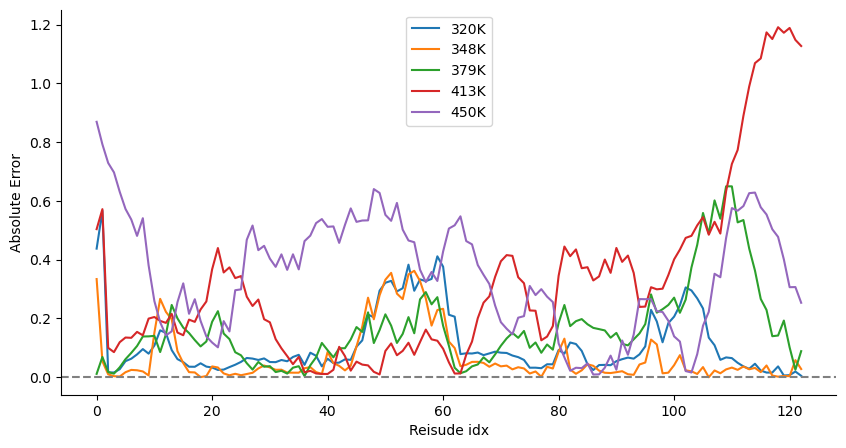

In [19]:
import seaborn as sns

temp_list = [320, 348, 379, 413, 450]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
for t, r in zip(temp_list, residuals):
    plt.plot(r, label=f"{t}K")
plt.axhline(0, color="gray", linestyle="--")
plt.xlabel("Reisude idx")
plt.ylabel("Absolute Error")
plt.legend()
sns.despine()
plt.show()

In [20]:
import pandas as pd

all_df = []
for t, r in zip(temp_list, residuals):
    tmpdf = pd.DataFrame(r, columns=["error"])
    tmpdf["temp"] = t
    tmpdf["residx"] = np.arange(len(r))
    tmpdf["resbin"] = pd.cut(tmpdf["residx"], bins=np.arange(0, 140, 10))
    all_df.append(tmpdf)
all_df = pd.concat(all_df)

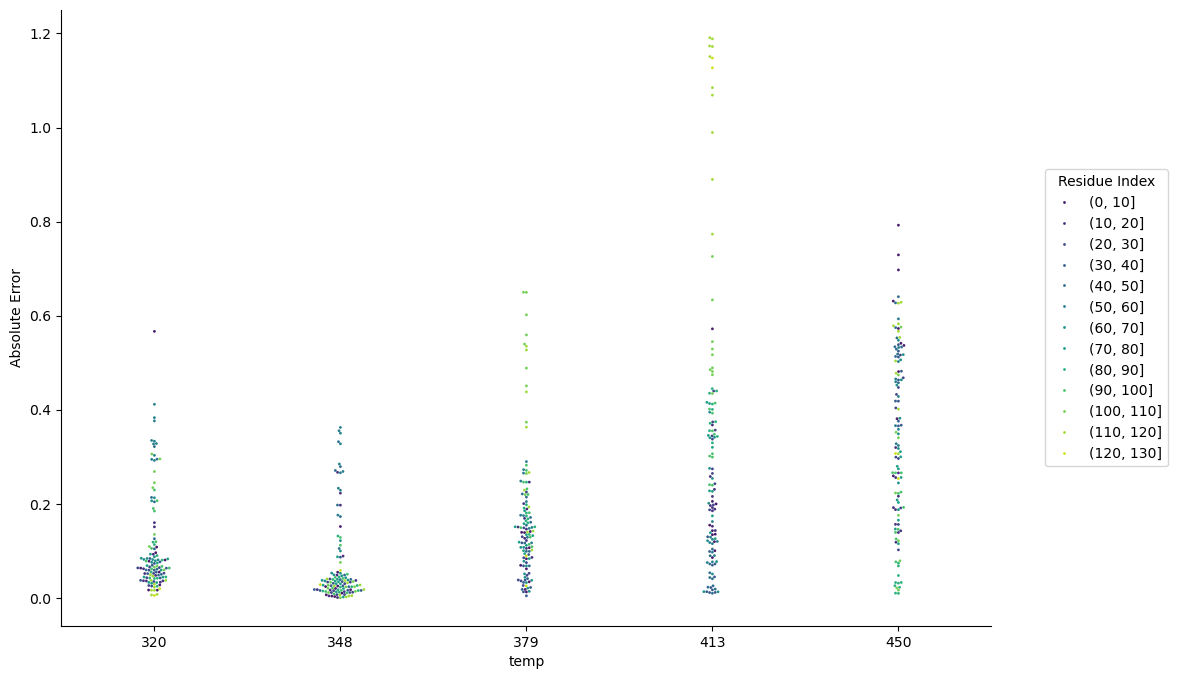

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
sns.swarmplot(all_df, x="temp", y="error", hue="resbin", palette="viridis", s=2)
plt.ylabel("Absolute Error")
plt.legend(bbox_to_anchor=(1.05, 0.5), loc="center left", title="Residue Index")
sns.despine()
plt.show()

---

In [1]:
fb, yb, lb = next(iter(adl.train_dataloader()))

NameError: name 'adl' is not defined

In [8]:
tform = model._transform((fb["seq_feats"], fb["struct_feats"]))

In [9]:
tform.shape, fb["temp"].shape

(torch.Size([8, 184, 256]), torch.Size([8, 184]))

In [10]:
torch.cat([tform, fb["temp"].unsqueeze(-1)], dim=-1).shape

torch.Size([8, 184, 257])

In [11]:
predb = model((fb["seq_feats"], fb["struct_feats"]))

TypeError: tuple indices must be integers or slices, not str

In [40]:
predb["ca_dist"].shape, yb["ca_dist"].shape, predb["rmsf"].shape, yb["rmsf"].shape

(torch.Size([8, 415, 415]),
 torch.Size([8, 415, 415]),
 torch.Size([8, 415, 1]),
 torch.Size([8, 415]))

In [41]:
from rocketshp.modeling.pt_lightning import (
    compute_masked_mse_loss,
    compute_square_masked_mse_loss,
)

In [42]:
compute_masked_mse_loss(predb["rmsf"], yb["rmsf"].unsqueeze(-1), lb, rmse=True)

tensor(0.0748, grad_fn=<SqrtBackward0>)

In [43]:
compute_square_masked_mse_loss(predb["ca_dist"], yb["ca_dist"], lb, rmse=True)

tensor(3.0609, grad_fn=<SqrtBackward0>)

In [44]:
x = model._transform((fb["seq_feats"], fb["struct_feats"]))

In [46]:
sqform_tensor = model.squareformer(
    (x.unsqueeze(1) * x.unsqueeze(2)).transpose(1, 3)
).squeeze()

In [49]:
sqform_tensor.shape, predb["ca_dist"].shape

(torch.Size([8, 415, 415]), torch.Size([8, 415, 415]))

## Testing Runtime

In [31]:
# Profile time it takes to run
import time

results = {}

start = time.time()
with torch.no_grad():
    for samp_i in tqdm(range(len(DATA_SUBSET))):
        feats, labels = DATA_SUBSET[SAMPLE_I]
        key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
        temp = int(key.split("/")[1].lstrip("T"))

        both_result = model({k: v.unsqueeze(0) for k, v in feats.items()})
        results[key] = both_result
end = time.time()
print(f"Elapsed time: {end - start}")
print(f"Time per sample: {(end - start) / len(DATA_SUBSET)}")

100%|██████████| 15550/15550 [03:34<00:00, 72.43it/s]

Elapsed time: 214.69730806350708
Time per sample: 0.013806900840096918
